# Modeling a High Resolution Reflection Spectrum

Hajime Kawahara June 30th (2024)

This code analyzes the reflection spectrum of Jupiter. We here try to solve two problems.
One is we need to calibrate the wavenumber grid of the data because the calibration lines were insufficient and the wavelength of the data is not accurate.
To do so, we use the reflection spectrum model itself. 
The other is, after the wavelenghtcalibration, we try to fit the model to the calibrated data.

This note coresponds to the other one, using the output of the code for the former one (Jupiter_Hires_Modeling_NIR_fitting.ipynb)

In [1]:
from jax import config
config.update("jax_enable_x64", False)


Forget about the following code. I need this to run the code somewhere...

In [2]:

#username="exoplanet01"
username="kawahara"
if username == "exoplanet01":
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context


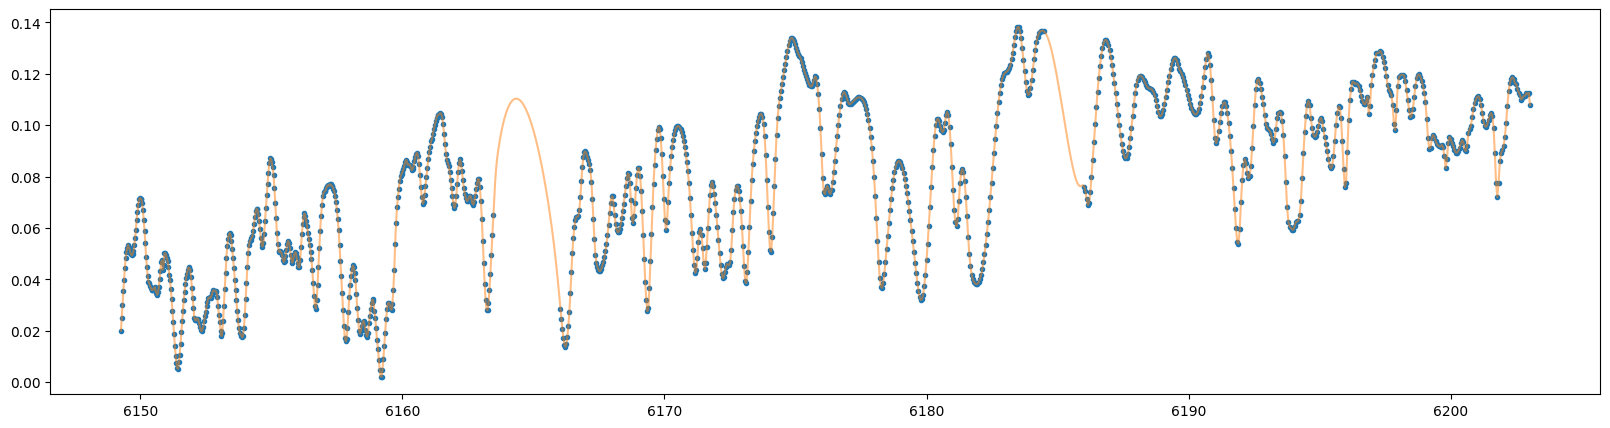

In [121]:
import numpy as np
import matplotlib.pyplot as plt
dat = np.loadtxt("jupiter_corrected.dat")
unmask_nus_obs = dat[:,0]
unmask_spectra = dat[:,1]

mask = (unmask_nus_obs<6163.5)+((unmask_nus_obs>6166)&(unmask_nus_obs < 6184.5)) + (unmask_nus_obs>6186)
nus_obs = unmask_nus_obs[mask]
spectra = unmask_spectra[mask]
fig = plt.figure(figsize=(20,5))
plt.plot(nus_obs, spectra, ".")
plt.plot(unmask_nus_obs, unmask_spectra, alpha=0.5)
plt.show()


## Solar spectrum

This is the reflected "solar" spectrum by Jupiter! So, we need the solar spectrum template.

I found very good one: High-resolution solar spectrum taken from Meftar et al. (2023) 

- 10.21413/SOLAR-HRS-DATASET.V1.1_LATMOS
- http://doi.latmos.ipsl.fr/DOI_SOLAR_HRS.v1.1.html
- http://bdap.ipsl.fr/voscat_en/solarspectra.html


In [122]:
from exojax.spec.unitconvert import wav2nu
import pandas as pd
#filename = "/home/kawahara/solar-hrs/Spectre_HR_LATMOS_Meftah_V1.txt"
filename = "/home/"+username+"/solar-hrs/Spectre_HR_LATMOS_Meftah_V1.txt"
dat = pd.read_csv(filename, names=("wav","flux"), comment=";", delimiter="\t")
dat["wav"] = dat["wav"]*10

wav_solar = dat["wav"][::-1]
solspec = dat["flux"][::-1]
nus_solar = wav2nu(wav_solar,unit="AA")


This is really the solar spectrum reflected by something...

(0.0, 0.25)

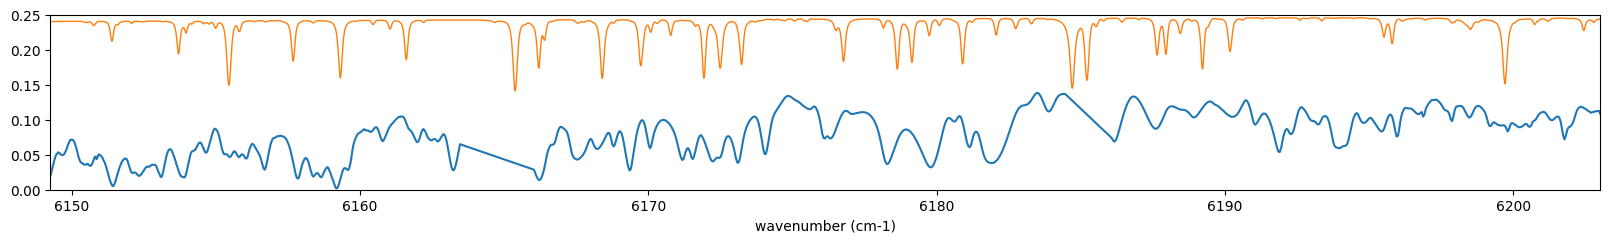

In [123]:
vrv = 10.0
vperc = vrv/300000

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(211)
plt.plot(nus_obs,spectra, label="masked spectrum")
plt.plot(nus_solar*(1.0+vperc),solspec,lw=1,label="Solar")
plt.xlabel("wavenumber (cm-1)")
plt.xlim(np.min(nus_obs),np.max(nus_obs))  
plt.ylim(0.0,0.25)

## Atmospheric Model Setting

See `Jupiter_cloud_model_using_amp.ipynb` 


In [124]:
# set the master wavenumber grid
from exojax.utils.grids import wavenumber_grid
nus, wav, res = wavenumber_grid(np.min(nus_obs)-5.0,np.max(nus_obs)+5.0,10000,xsmode="premodit",unit="cm-1")
print(res)

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: mode=premodit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
968619.7022514157


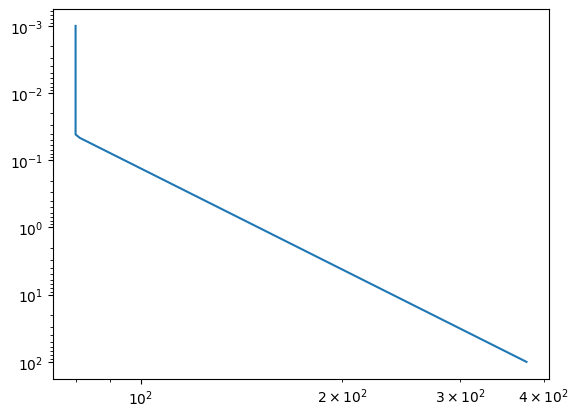

In [125]:
from exojax.spec.atmrt import ArtReflectPure
from exojax.utils.astrofunc import gravity_jupiter
art = ArtReflectPure(nu_grid=nus, pressure_btm=1.0e2, pressure_top=1.0e-3, nlayer=100)
art.change_temperature_range(80.0, 400.0)
Tarr = art.powerlaw_temperature(150.0, 0.2)
Parr = art.pressure

mu = 2.3  # mean molecular weight
gravity = gravity_jupiter(1.0, 1.0)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Tarr, art.pressure)
ax.invert_yaxis()
plt.yscale("log")
plt.xscale("log")
plt.show()

In [171]:


from exojax.spec.pardb import PdbCloud
from exojax.atm.atmphys import AmpAmcloud

pdb_nh3 = PdbCloud("NH3")
amp_nh3 = AmpAmcloud(pdb_nh3, bkgatm="H2")
amp_nh3.check_temperature_range(Tarr)

#condensate substance density
rhoc = pdb_nh3.condensate_substance_density #g/cc

from exojax.utils.zsol import nsol
from exojax.atm.mixratio import vmr2mmr
from exojax.spec.molinfo import molmass_isotope

n = nsol()  #solar abundance
abundance_nh3 = n["N"]
molmass_nh3 = molmass_isotope("NH3", db_HIT=False)

#fsed = 10.
fsed = 3.0
sigmag = 2.0
Kzz = 1.e4
MMRbase_nh3 = vmr2mmr(abundance_nh3, molmass_nh3, mu) 

rg_layer, MMRc = amp_nh3.calc_ammodel(Parr, Tarr, mu, molmass_nh3, gravity, fsed, sigmag, Kzz, MMRbase_nh3)


.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  .database/particulates/virga/NH3.refrind
Miegrid file does not exist at  .database/particulates/virga/miegrid_lognorm_NH3.mg.npz
Generate miegrid file using pdb.generate_miegrid if you use Mie scattering


/home/kawahara/exojax/src/exojax/atm/atmphys.py:50: UserWarning: min temperature 80.0 K is smaller than min(vfactor t range) 179.10000610351562 K
  warnings.warn(


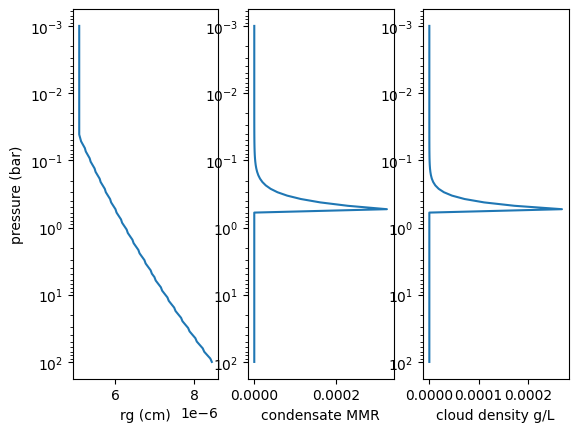

In [172]:
import matplotlib.pyplot as plt

# to convert MMR to g/L ... 
from exojax.atm.idealgas import number_density
from exojax.utils.constants import m_u
fac = molmass_nh3*m_u*number_density(Parr,Tarr)*1.e3 #g/L 

fig = plt.figure()
ax = fig.add_subplot(131)
plt.plot(rg_layer, Parr)
plt.xlabel("rg (cm)")
plt.ylabel("pressure (bar)")
plt.yscale("log")
ax.invert_yaxis()
ax = fig.add_subplot(132)
plt.plot(MMRc, Parr)
plt.xlabel("condensate MMR")
plt.yscale("log")
#plt.xscale("log")
ax.invert_yaxis()
ax = fig.add_subplot(133)
plt.plot(fac*MMRc, Parr)
plt.xlabel("cloud density g/L")
plt.yscale("log")
#plt.xscale("log")
ax.invert_yaxis()

In [173]:
rg = 1.e-5

from exojax.spec.opacont import OpaMie
opa_nh3 = OpaMie(pdb_nh3, nus)
#sigma_extinction, sigma_scattering, asymmetric_factor = opa.mieparams_vector(rg,sigmag) # if using MieGrid
sigma_extinction, sigma_scattering, asymmetric_factor = opa_nh3.mieparams_vector_direct_from_pymiescatt(rg, sigmag)


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


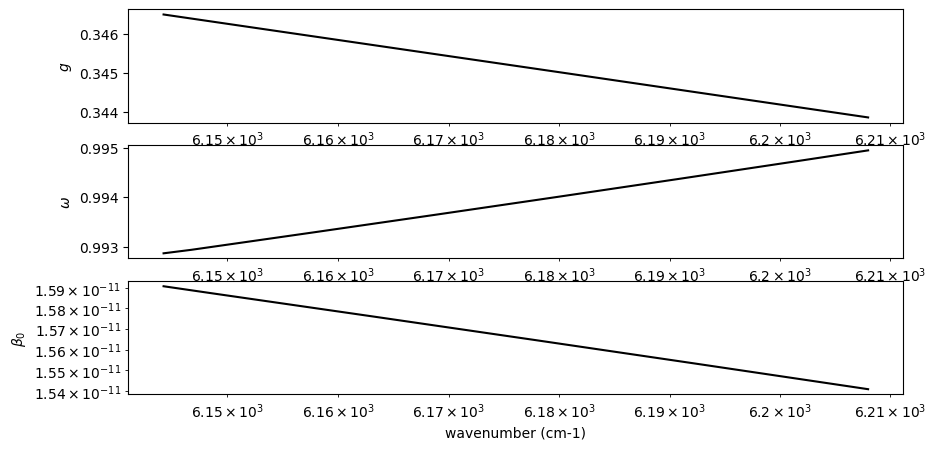

In [174]:
# plt.plot(pdb_nh3.refraction_index_wavenumber, miepar[50,:,0])
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(311)
plt.plot(nus, asymmetric_factor, color="black")
plt.xscale("log")
plt.ylabel("$g$")
ax = fig.add_subplot(312)
plt.plot(nus, sigma_scattering/sigma_extinction, label="single scattering albedo", color="black")
plt.xscale("log")
plt.ylabel("$\\omega$")
ax = fig.add_subplot(313)
plt.plot(nus, sigma_extinction, label="ext", color="black")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("$\\beta_0$")
plt.savefig("miefig_high.png")

Next, we consider the gas component, i.e. methane

In [175]:
from exojax.spec.api import MdbHitemp

Oh, we need HITEMP because our observation is in visible band, i.e., we need higher energy states.

In [176]:
Eopt = 3300.0 # this is from the Elower optimization result
#mdb_reduced = MdbHitemp("CH4", nurange=[nus_start,nus_end], isotope=1, elower_max=Eopt)
mdb_reduced = MdbHitemp("CH4", nurange=[nus[0],nus[-1]], isotope=1, elower_max=Eopt)

In [177]:
from exojax.spec.opacalc import OpaPremodit
opa = OpaPremodit(mdb_reduced, nu_grid=nus, allow_32bit=True, auto_trange=[80.0, 300.0]) #this reduced the device memory use in 5/6.
#opa = OpaPremodit(mdb, nu_grid=nus, allow_32bit=True, auto_trange=[80.0, 300.0]) #this reduced the device memory use in 5/6.

/home/kawahara/exojax/src/exojax/utils/jaxstatus.py:19: UserWarning: JAX is 32bit mode. We recommend to use 64bit mode. 
You can change to 64bit mode by writing 

    from jax import config 
    config.update("jax_enable_x64", True)

  warnings.warn(msg+how_change_msg)
/home/kawahara/exojax/src/exojax/spec/api.py:567: RuntimeWarning: divide by zero encountered in log
  self.logsij0 = np.log(self.line_strength_ref)


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 79.45501192821337 - 740.1245313998245 K
Change the reference temperature from 296.0K to 91.89455622053987 K.
OpaPremodit: Tref_broadening is set to  154.91933384829665 K
OpaPremodit: gamma_air and n_air are used. gamma_ref = gamma_air/Patm
# of reference width grid :  7
# of temperature exponent grid : 4


uniqidx: 100%|██████████| 8/8 [00:00<00:00, 1261.97it/s]


Premodit: Twt= 328.42341041740974 K Tref= 91.89455622053987 K
Making LSD:|####################| 100%


In [178]:
dtau_cld = art.opacity_profile_cloud_lognormal(sigma_extinction, rhoc, MMRc, rg, sigmag, gravity)

# Spectrum Model

In [179]:
import jax.numpy as jnp
nusjax = jnp.array(nus)
nusjax_solar = jnp.array(nus_solar)
solspecjax = jnp.array(solspec)


### gas opacity 

In [180]:
molmass_ch4 = molmass_isotope("CH4", db_HIT=False)

dtau_cld_scat = art.opacity_profile_cloud_lognormal(sigma_scattering, rhoc, MMRc, rg, sigmag, gravity)
sigma_scattering[None,:]/sigma_extinction[None,:] + np.zeros((len(art.pressure), len(nus)))
asymmetric_parameter = asymmetric_factor + np.zeros((len(art.pressure), len(nus))) 
reflectivity_surface = np.zeros(len(nus))

In [181]:
from exojax.utils.instfunc import resolution_to_gaussian_std
from exojax.spec.specop import SopInstProfile
sop = SopInstProfile(nus)

from exojax.utils.constants import c #light speed in km/s


In [188]:
parinit = jnp.array([-5.0, -55.0, 2.5, 1.0, 1.0])
multiple_factor = jnp.array([1.0, 1.0, 10000.0, 0.01, 1.0])

def unpack_params(params):
    return params*multiple_factor

In [189]:
def spectral_model(params):

    #vrv, vv, broadening, const_mmr_ch4 = params*multiple_factor
    vrv, vv, _, const_mmr_ch4, factor = params*multiple_factor
    # vrv = -5.0
    # vv = -55.0
    broadening = 25000.0
    # const_mmr_ch4 = 0.01


    # cloud
    #rg_layer, MMRc = amp_nh3.calc_ammodel(Parr, Tarr, mu, molmass_nh3, gravity, fsed, sigmag, Kzz, MMRbase_nh3)
    #rg = jnp.mean(rg_layer)
    #sigma_extinction, sigma_scattering, asymmetric_factor = opa_nh3.mieparams_vector_direct_from_pymiescatt(rg, sigmag)
    #dtau_cld_scat = art.opacity_profile_cloud_lognormal(sigma_scattering, rhoc, MMRc, rg, sigmag, gravity)
    #asymmetric_parameter = asymmetric_factor + np.zeros((len(art.pressure), len(nus))) 

    # opacity
    mmr_ch4 = art.constant_mmr_profile(const_mmr_ch4)  # (*_*)/~
    xsmatrix = opa.xsmatrix(Tarr, Parr)
    dtau_ch4 = art.opacity_profile_xs(xsmatrix, mmr_ch4, molmass_ch4, gravity)
    
    
    single_scattering_albedo = (dtau_cld_scat) / (dtau_cld + dtau_ch4)
    
    dtau = dtau_cld + dtau_ch4

    # velocity

    vpercp = (vrv + vv) / c
    incoming_flux = jnp.interp(nusjax, nusjax_solar * (1.0 + vpercp), solspecjax)

    Fr = art.run(
        dtau,
        single_scattering_albedo,
        asymmetric_parameter,
        reflectivity_surface,
        incoming_flux,
    )

    
    std = resolution_to_gaussian_std(broadening)
    Fr_inst = sop.ipgauss(Fr, std)
    Fr_samp = sop.sampling(Fr_inst, vv, nus_obs)

    return factor*Fr_samp

In [190]:
def cost_function(params):
    return jnp.sum((spectra - spectral_model(params))**2)

OK, uses the solar spectrum as an incomning spectrum! 

In [191]:


from jaxopt import OptaxSolver
import optax
adam = OptaxSolver(opt=optax.adam(1.e-2), fun=cost_function)
res = adam.run(parinit)
#maxiter = 100
#solver = jaxopt.LBFGS(fun=cost_function, maxiter=maxiter)
#res = solver.run(optpar_init)


In [192]:
#res.params
print(unpack_params(res.params))
print(unpack_params(parinit))

[-1.062730e+00 -5.801974e+01  2.500000e+04  1.765638e-02  5.888484e-01]
[-5.0e+00 -5.5e+01  2.5e+04  1.0e-02  1.0e+00]


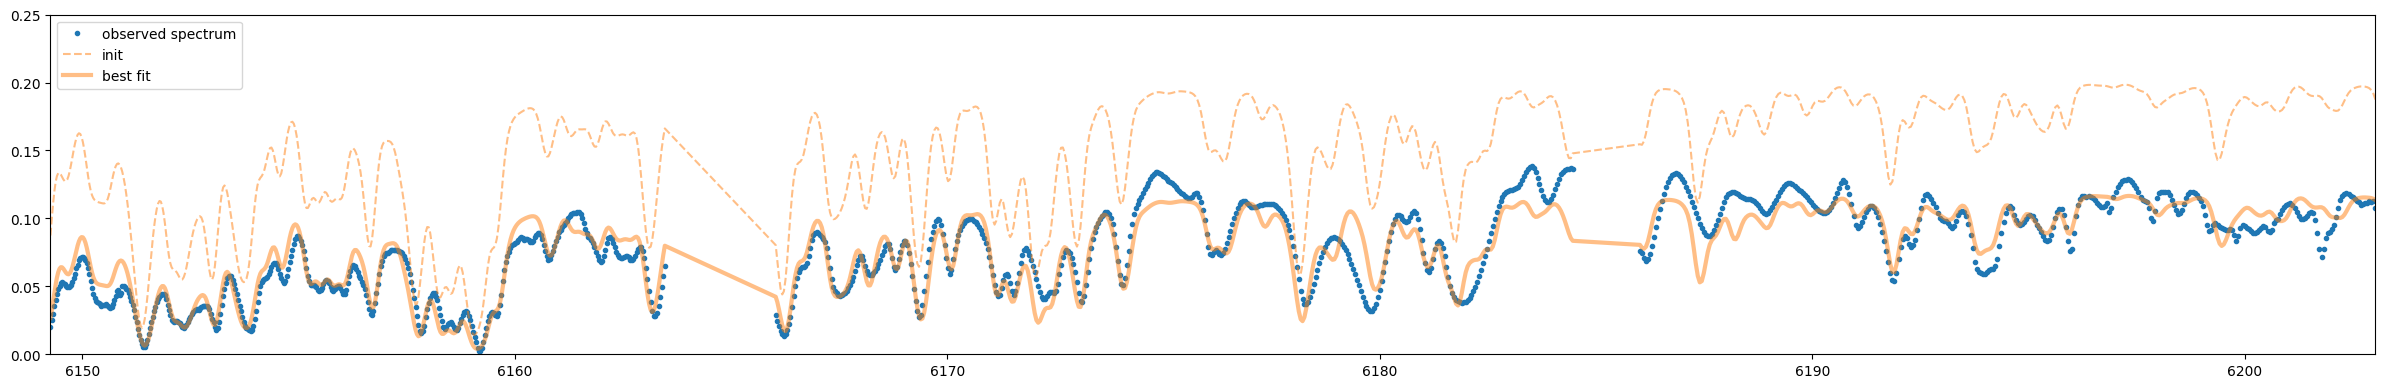

In [195]:
F_samp = spectral_model(res.params)
F_samp_init = spectral_model(parinit)

fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(311)
plt.plot(nus_obs,spectra, ".", label="observed spectrum")
plt.plot(nus_obs,F_samp_init,alpha=0.5,label="init",color="C1",ls="dashed")
plt.plot(nus_obs,F_samp,alpha=0.5,label="best fit",color="C1",lw=3)
#plt.plot(nus,Fr_samp,alpha=0.5,label="forward modelling",color="C1")
#plt.plot(nus*(1-vpercp_only_show_solar),incoming_flux, label="incoming",color="C2")
plt.legend()
plt.xlim(np.min(nus_obs),np.max(nus_obs))
plt.ylim(0.0,0.25)
plt.show()